# Feature Engineering & Selection — Corrected Notebook with Explanations

This notebook demonstrates **feature engineering and selection** on the Titanic dataset.  
We will cover:  
1. Data cleaning & imputation  
2. Encoding categorical variables  
3. Feature scaling  
4. Train/test split  
5. Filter, Wrapper, and Embedded feature selection methods  
6. Final pipeline with preprocessing + feature selection + model  
Each code cell is preceded by explanation in markdown.

## Imports and dataset load
We import libraries and load the Titanic dataset from seaborn.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load Titanic dataset
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Data cleaning & preprocessing
We inspect missing values, impute them, and drop redundant columns.

In [2]:
print("Missing values before:")
print(df.isnull().sum())

# Imputers
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

df[["age"]] = imputer_num.fit_transform(df[["age"]])
df[["embarked"]] = imputer_cat.fit_transform(df[["embarked"]])

# Drop irrelevant/leaky columns
cols_to_drop = ["deck", "embark_town", "alive", "class", "who", "adult_male"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("\nMissing values after imputation:")
print(df.isnull().sum())
df.head()

Missing values before:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Missing values after imputation:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
alone       0
dtype: int64


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,male,22.0,1,0,7.2500,S,False
1,1,1,female,38.0,1,0,71.2833,C,False
2,1,3,female,26.0,0,0,7.9250,S,True
3,1,1,female,35.0,1,0,53.1000,S,False
4,0,3,male,35.0,0,0,8.0500,S,True


## Encoding categorical variables
We encode categorical features into numeric codes.

In [3]:
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print("Remaining object columns:", df.select_dtypes(include=['object']).columns.tolist())
df.head()

Categorical columns: ['sex', 'embarked']
Remaining object columns: []


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,1,22.0,1,0,7.2500,2,False
1,1,1,0,38.0,1,0,71.2833,0,False
2,1,3,0,26.0,0,0,7.9250,2,True
3,1,1,0,35.0,1,0,53.1000,2,False
4,0,3,1,35.0,0,0,8.0500,2,True


## Feature scaling
We standardize numeric features and keep a MinMax copy for chi2 if needed.

In [4]:
num_cols = ['age','fare']

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

df[num_cols] = scaler_std.fit_transform(df[num_cols])
df_mm = df.copy()
df_mm[num_cols] = scaler_mm.fit_transform(df_mm[num_cols])

df[num_cols].describe()

,age,fare
count,8.910000e+02,8.910000e+02
mean,2.272780e-16,3.987333e-18
std,1.000562e+00,1.000562e+00
min,-2.224156e+00,-6.484217e-01
25%,-5.657365e-01,-4.891482e-01
50%,-1.046374e-01,-3.573909e-01
75%,4.333115e-01,-2.424635e-02
max,3.891554e+00,9.667167e+00


## Train/test split
We separate features (X) and target (y), then split.

In [5]:
X = df.drop(columns=["survived"]) if "survived" in df.columns else df.copy()
y = df["survived"]

non_numeric = X.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

Non-numeric columns: []


(623, 8)

## Filter method (Mutual Information)
We use `SelectKBest(mutual_info_classif)` to rank features.

In [6]:
selector = SelectKBest(score_func=mutual_info_classif, k=5)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]
print("Top 5 features (Mutual Info):", list(selected_features))

Top 5 features (Mutual Info): ['pclass', 'sex', 'parch', 'fare', 'embarked']


## Wrapper method (RFE)
Recursive Feature Elimination using Logistic Regression.

In [7]:
estimator = LogisticRegression(max_iter=1000)
rfe = RFE(estimator, n_features_to_select=5)
rfe.fit(X_train, y_train)

rfe_features = X_train.columns[rfe.get_support()]
print("Top 5 features (RFE):", list(rfe_features))

Top 5 features (RFE): ['pclass', 'sex', 'age', 'sibsp', 'alone']


## Embedded method (Random Forest)
We fit a Random Forest and inspect feature importances.

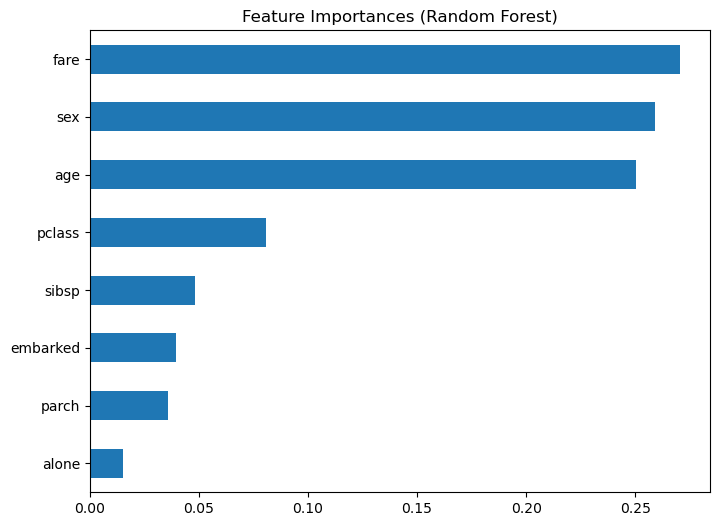

fare        0.270760
sex         0.259140
age         0.250403
pclass      0.080791
sibsp       0.048387
embarked    0.039522
parch       0.035846
alone       0.015152
dtype: float64

In [8]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importances (Random Forest)")
plt.show()

importances.sort_values(ascending=False).head(10)

## Full Pipeline (Best Practice)
We combine preprocessing, feature selection, and model into one pipeline to avoid data leakage.

In [9]:
num_cols = ['age','fare','sibsp','parch']
cat_cols = ['sex','embarked']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

pipe = Pipeline([
    ('prep', preprocessor),
    ('select', SelectKBest(mutual_info_classif, k=8)),
    ('clf', RandomForestClassifier(random_state=42))
])

scores = cross_val_score(pipe, df.drop(columns=['survived']), df['survived'], cv=5, scoring='roc_auc')
print("CV ROC-AUC mean:", scores.mean(), "std:", scores.std())

CV ROC-AUC mean: 0.8503276778673902 std: 0.02926501667733416
